In [39]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [40]:
# Load breast cancer dataset
# Dataset contains features of cell nuclei with diagnosis (M=Malignant, B=Benign)
data = pd.read_csv("Datasets\data.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [41]:
# Data preprocessing and train-test split
X = data.drop(columns=['diagnosis', 'id']).values

# Direct encoding: M=1 (Malignant), B=-1 (Benign) 
y = data['diagnosis'].map({'M': 1, 'B': -1}).values

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f"Label distribution - Malignant (1): {np.sum(y_train == 1)}, Benign (-1): {np.sum(y_train == -1)}")

(455, 30) (114, 30) (455,) (114,)
Label distribution - Malignant (1): 169, Benign (-1): 286


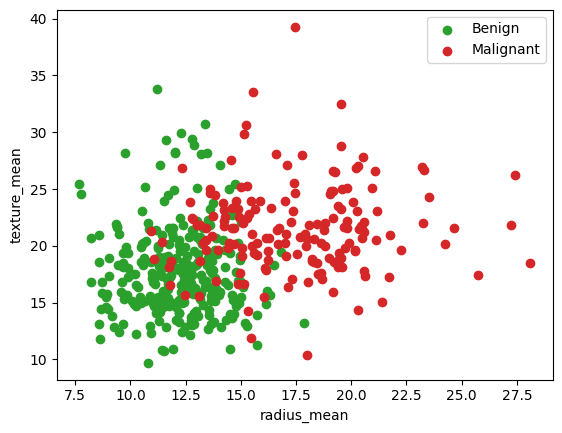

In [42]:
# Visualize data distribution
benign_points = X_train[y_train == -1]
malignant_points = X_train[y_train== 1]

# Create a scatter plot to visualize the data distribution
plt.scatter(benign_points[:, 0], benign_points[:, 1], color="tab:green", label="Benign")
plt.scatter(malignant_points[:, 0], malignant_points[:, 1], color="tab:red", label="Malignant")
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.legend()
plt.show()

In [43]:
# SVM implementation from scratch
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, batch_size=32):
        # Initialize hyperparameters
        self.lr = learning_rate
        self.lambda_param = lambda_param  # Regularization parameter
        self.n_iters = n_iters
        self.batch_size = batch_size
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        # Initialize weights and bias
        n_samples, n_features = X.shape
        self.w = np.random.normal(0, 0.01, n_features)
        self.b = 0

        y_flat = y.flatten()

        # Training loop with mini-batch gradient descent
        for i in range(self.n_iters):
            # Shuffle data for each epoch
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y_flat[indices]

            # Process data in mini-batches
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Initialize gradients
                dw = np.zeros_like(self.w)
                db = 0

                # Compute margins for the batch
                margins = y_batch * (np.dot(X_batch, self.w) - self.b)
                wrong_margin = margins < 1  # Support vectors and misclassified points

                # Regularization term (always applied)
                dw += 2 * self.lambda_param * self.w

                # Hinge loss gradient for support vectors
                if np.any(wrong_margin):
                    X_wrong = X_batch[wrong_margin]
                    y_wrong = y_batch[wrong_margin]

                    dw -= np.sum(y_wrong.reshape(-1, 1) * X_wrong, axis=0)
                    db -= np.sum(-y_wrong)
                
                # Average gradients over batch
                dw = dw / len(X_batch)
                db = db / len(X_batch)

                # Update parameters
                self.w = self.w - self.lr * dw
                self.b = self.b - self.lr * db

            if i % 100 == 0:
                print(f"Iteration {i}: Weights norm = {np.linalg.norm(self.w):.4f}, Bias = {self.b:.4f}")

    def predict(self, X):
        # Make predictions using the decision function
        predictions = np.dot(X, self.w) - self.b
        return np.sign(predictions)  # Return -1 or 1

In [44]:
# Feature scaling for better SVM performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

# Train custom SVM model and evaluate performance
svm_model = SVM(learning_rate=0.0001, lambda_param=0.01, n_iters=2000, batch_size=64)
svm_model.fit(X_train_scaled, y_train)

predictions = svm_model.predict(X_test_scaled)

Iteration 0: Weights norm = 0.0473, Bias = 0.0002
Iteration 100: Weights norm = 0.2028, Bias = 0.0222
Iteration 200: Weights norm = 0.3131, Bias = 0.0478
Iteration 300: Weights norm = 0.3740, Bias = 0.0671
Iteration 400: Weights norm = 0.4175, Bias = 0.0828
Iteration 500: Weights norm = 0.4496, Bias = 0.0953
Iteration 300: Weights norm = 0.3740, Bias = 0.0671
Iteration 400: Weights norm = 0.4175, Bias = 0.0828
Iteration 500: Weights norm = 0.4496, Bias = 0.0953
Iteration 600: Weights norm = 0.4766, Bias = 0.1048
Iteration 700: Weights norm = 0.5016, Bias = 0.1139
Iteration 800: Weights norm = 0.5237, Bias = 0.1221
Iteration 600: Weights norm = 0.4766, Bias = 0.1048
Iteration 700: Weights norm = 0.5016, Bias = 0.1139
Iteration 800: Weights norm = 0.5237, Bias = 0.1221
Iteration 900: Weights norm = 0.5430, Bias = 0.1299
Iteration 1000: Weights norm = 0.5621, Bias = 0.1372
Iteration 1100: Weights norm = 0.5798, Bias = 0.1439
Iteration 900: Weights norm = 0.5430, Bias = 0.1299
Iteration 10

In [46]:
accuracy = np.mean(predictions == y_test)
confunction_mtx = confusion_matrix(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)

print(f"SVM Test Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(confunction_mtx)
print("Classification Report:")
print(classification_report_str)

SVM Test Accuracy: 98.25%
Confusion Matrix:
[[70  1]
 [ 1 42]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [47]:
# Compare with sklearn SVM implementation (using linear kernel)
from sklearn import svm

# Use linear kernel for fair comparison with custom implementation
sklearn_svm_model = svm.SVC(kernel='linear', C=0.1, max_iter=2000)
sklearn_svm_model.fit(X_train_scaled, y_train)

predictions_sklearn = sklearn_svm_model.predict(X_test_scaled)
sklearn_accuracy = np.mean(predictions_sklearn == y_test)
confunction_mtx_sklearn = confusion_matrix(y_test, predictions_sklearn)
classification_report_sklearn = classification_report(y_test, predictions_sklearn)

print(f"Sklearn Linear SVM Test Accuracy: {sklearn_accuracy * 100:.2f}%")
print("Confusion Matrix (Sklearn):")
print(confunction_mtx_sklearn)
print("Classification Report (Sklearn):")
print(classification_report_sklearn)


Sklearn Linear SVM Test Accuracy: 98.25%
Confusion Matrix (Sklearn):
[[71  0]
 [ 2 41]]
Classification Report (Sklearn):
              precision    recall  f1-score   support

          -1       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [48]:
# Function to plot decision boundary for SVM models
def plot_decision_boundary(X, y, model, title, scaler=None, custom_svm=False):
    """
    Plot decision boundary for SVM model using radius_mean (feature 0) and texture_mean (feature 1)
    """
    # Use only the first two features (radius_mean, texture_mean)
    X_2d = X[:, :2]
    
    # Create a mesh for plotting decision boundary
    h = 0.01  # Step size in the mesh
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create mesh points for prediction
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # For custom SVM, we need to use only 2 features
    if custom_svm:
        # Train a new SVM model with only 2 features for visualization
        temp_svm = SVM(learning_rate=0.0001, lambda_param=0.01, n_iters=2000, batch_size=64)
        X_2d_scaled = scaler.fit_transform(X_2d) if scaler else X_2d
        temp_svm.fit(X_2d_scaled, y)
        
        # Scale mesh points if scaler is provided
        if scaler:
            mesh_points_scaled = scaler.transform(mesh_points)
            Z = temp_svm.predict(mesh_points_scaled)
        else:
            Z = temp_svm.predict(mesh_points)
    else:
        # For sklearn SVM, we can use the existing model but need to extend mesh points
        # to match the feature dimensions
        n_features = model.n_features_in_
        mesh_extended = np.zeros((mesh_points.shape[0], n_features))
        mesh_extended[:, :2] = mesh_points  # Set first two features
        # Set remaining features to mean values from training data
        for i in range(2, n_features):
            mesh_extended[:, i] = X[:, i].mean()
        
        Z = model.predict(mesh_extended)
    
    # Reshape Z to match the mesh grid
    Z = Z.reshape(xx.shape)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.contour(xx, yy, Z, colors='black', linestyles='--', linewidths=1)
    
    # Plot training points
    benign_mask = y == -1
    malignant_mask = y == 1
    
    plt.scatter(X_2d[benign_mask, 0], X_2d[benign_mask, 1], 
                c='green', marker='o', s=50, alpha=0.7, label='Benign (-1)')
    plt.scatter(X_2d[malignant_mask, 0], X_2d[malignant_mask, 1], 
                c='red', marker='s', s=50, alpha=0.7, label='Malignant (1)')
    
    plt.xlabel('radius_mean')
    plt.ylabel('texture_mean')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Custom SVM Decision Boundary (using radius_mean and texture_mean)
Iteration 0: Weights norm = 0.0031, Bias = 0.0002
Iteration 100: Weights norm = 0.0635, Bias = 0.0211
Iteration 200: Weights norm = 0.1278, Bias = 0.0416
Iteration 300: Weights norm = 0.1921, Bias = 0.0616
Iteration 400: Weights norm = 0.2563, Bias = 0.0818
Iteration 500: Weights norm = 0.3196, Bias = 0.1026
Iteration 600: Weights norm = 0.3814, Bias = 0.1235
Iteration 700: Weights norm = 0.4402, Bias = 0.1457
Iteration 800: Weights norm = 0.4939, Bias = 0.1674
Iteration 900: Weights norm = 0.5433, Bias = 0.1882
Iteration 1000: Weights norm = 0.5888, Bias = 0.2074
Iteration 1100: Weights norm = 0.6293, Bias = 0.2259
Iteration 1200: Weights norm = 0.6659, Bias = 0.2422
Iteration 1300: Weights norm = 0.6984, Bias = 0.2571
Iteration 1400: Weights norm = 0.7285, Bias = 0.2717
Iteration 1500: Weights norm = 0.7556, Bias = 0.2850
Iteration 1600: Weights norm = 0.7812, Bias = 0.2972
Iteration 1700: Weights norm = 0.8054, Bias =

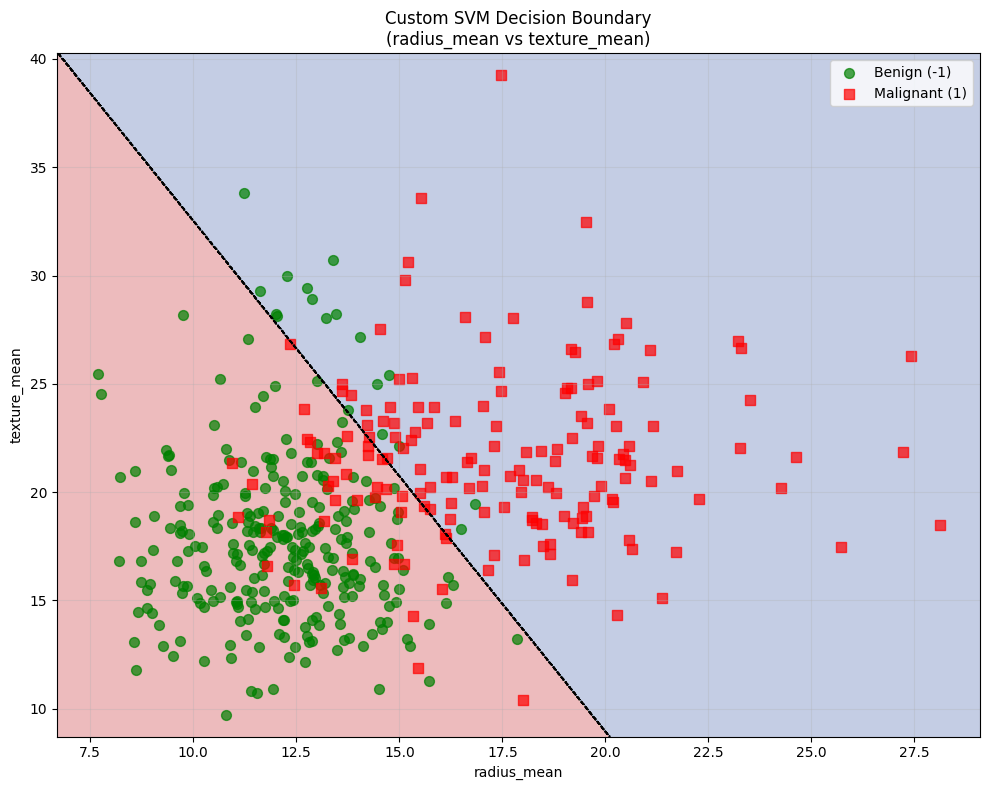

In [49]:
# Visualize Custom SVM Decision Boundary
print("Custom SVM Decision Boundary (using radius_mean and texture_mean)")
scaler_2d = StandardScaler()  # Create a new scaler for 2D visualization
plot_decision_boundary(X_train, y_train, None, 
                      'Custom SVM Decision Boundary\n(radius_mean vs texture_mean)', 
                      scaler=scaler_2d, custom_svm=True)

Scikit-learn SVM Decision Boundary (using radius_mean and texture_mean)


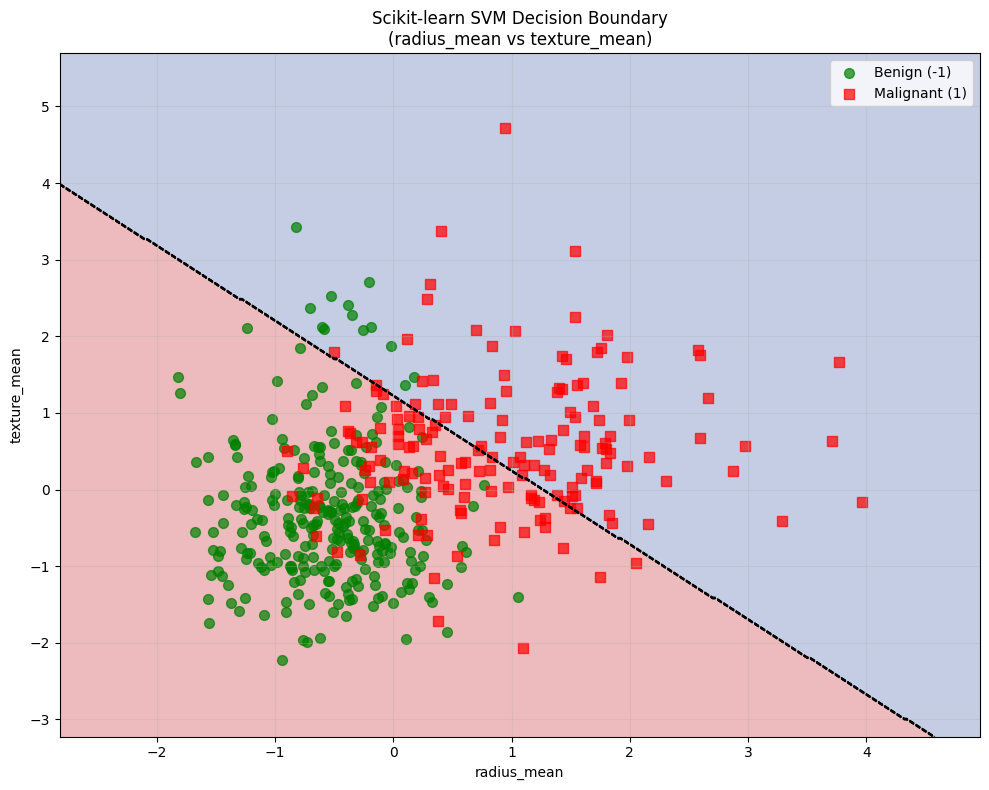

In [50]:
# Visualize Scikit-learn SVM Decision Boundary
print("Scikit-learn SVM Decision Boundary (using radius_mean and texture_mean)")
plot_decision_boundary(X_train_scaled, y_train, sklearn_svm_model, 
                      'Scikit-learn SVM Decision Boundary\n(radius_mean vs texture_mean)', 
                      custom_svm=False)